In [2]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import sys
sys.path.append("../")
import nextgems as ng

In [3]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [4]:
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3']))

['2D_1h_native', '3D_1h6h_native', '2D_monthly_native', '3D_monthly_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_1h_0.25deg', '3D_1h6h_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', '2D_1h_1deg', '3D_1h6h_1deg', 'WAM_1h_native']


In [5]:
data = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_1h_native'].to_dask()

In [6]:
data

<xarray.Dataset>
Dimensions:  (time: 43394, value: 26306560)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01
Dimensions without coordinates: value
Data variables: (12/59)
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2t       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    tisr     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    tp       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    tsr      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ttr      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    zos      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [7]:
model_lon = data.lon.values
model_lat = data.lat.values
nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
points_ifs = np.vstack((lon_nonan, lat_nonan)).T

In [8]:
bbox = [-10, 80, -50, -20]

Check how teh map boundaries will look like

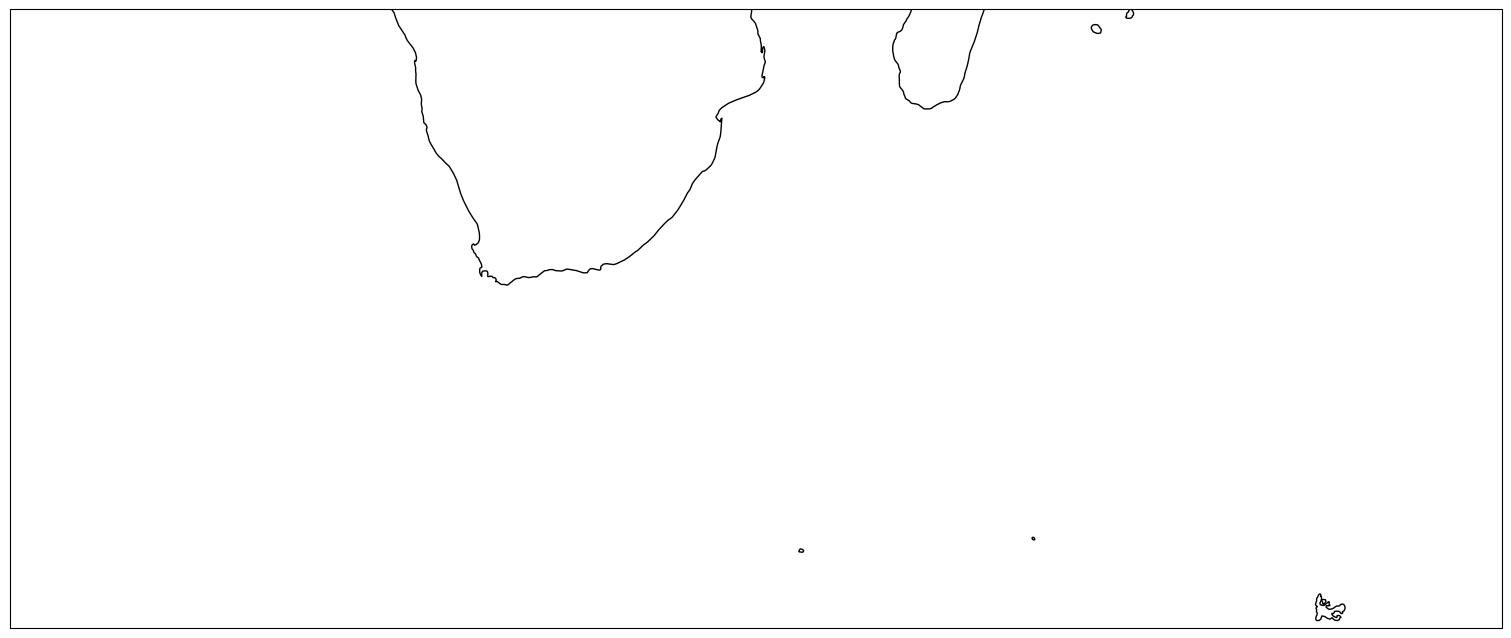

In [9]:
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.Mercator()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.coastlines()

In [10]:
x, y, lon2, lat2 = ng.projected_grid_to_platecarree_pyproj(bbox, [1000, 500], projection="World_Mercator", n_points=100)

In [11]:
distances, inds = ng.create_indexes_and_distances(model_lon, model_lat, lon2, lat2, k=1, workers=10)

In [12]:
data_sample = data['ocu'][1106,:]
data_sample2 = data['2t'][1106,:]

radius_of_influence=5000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

data_interpolated2 = data_sample2.values[inds]
data_interpolated2[distances >= radius_of_influence] = np.nan
data_interpolated2 = data_interpolated2.reshape(lon2.shape)
data_interpolated2 = np.ma.masked_invalid(data_interpolated2)

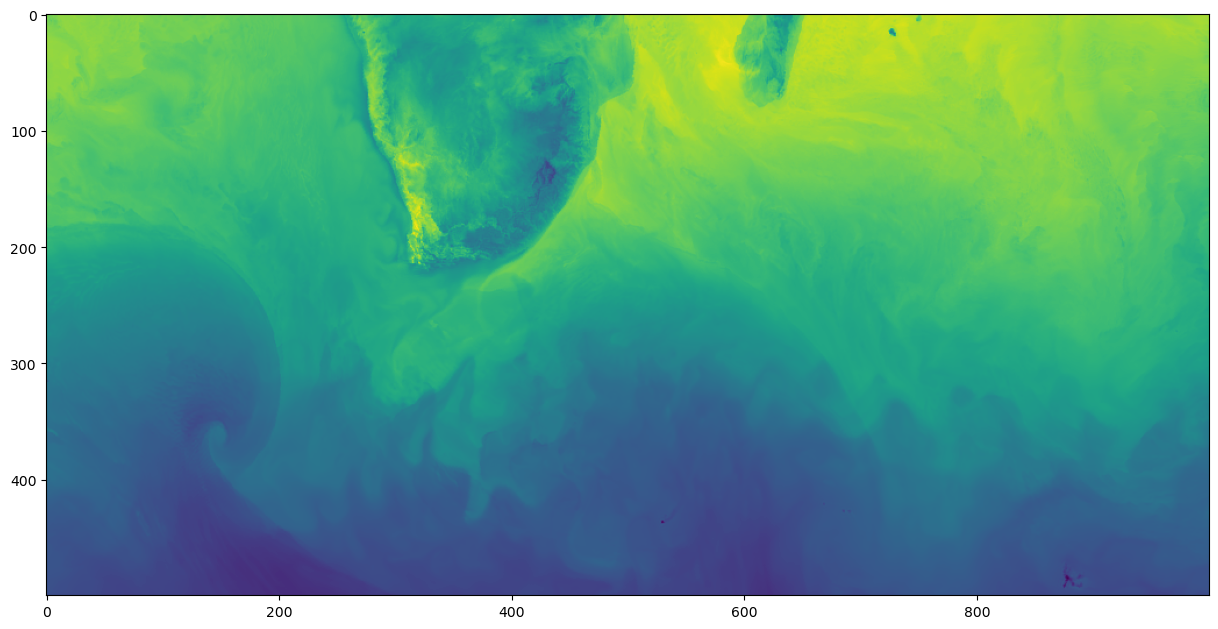

In [13]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(data_interpolated2))

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

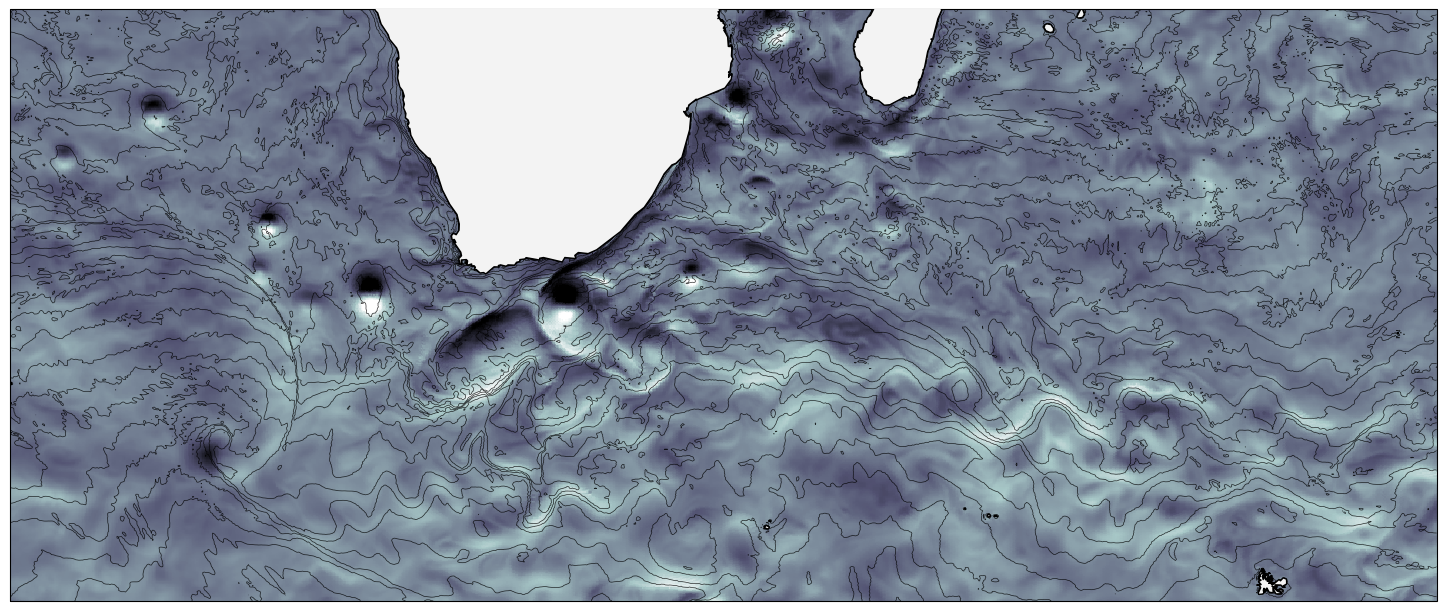

In [14]:
for i in range(1106,1107):
    data_sample = data['ocu'][i,:]
    data_sample2 = data['2t'][i,:]

    radius_of_influence=5000
    data_interpolated = data_sample.values[inds]
    data_interpolated[distances >= radius_of_influence] = np.nan
    data_interpolated = data_interpolated.reshape(lon2.shape)
    data_interpolated = np.ma.masked_invalid(data_interpolated)

    data_interpolated2 = data_sample2.values[inds]
    data_interpolated2[distances >= radius_of_influence] = np.nan
    data_interpolated2 = data_interpolated2.reshape(lon2.shape)
    data_interpolated2 = np.ma.masked_invalid(data_interpolated2)

    fig, ax = plt.subplots(
                1,
                1,
                subplot_kw=dict(projection=ccrs.Mercator()),
                constrained_layout=True,
                figsize=(15,6),
            )
    ax.set_extent(bbox, crs=ccrs.PlateCarree())
    data_levels = np.linspace(-0.5, 0.5, 31)
    colormap = cm.bone
    image = ax.pcolormesh(
                    lon2,
                    lat2,
                    data_interpolated,
                    vmin=-1.3,
                    vmax=1.3,
                    # levels=data_levels,
                    transform=ccrs.PlateCarree(),
                    cmap=colormap,
                    # extend="both",
                )
    data_levels2=np.linspace(260,300, 41)
    colormap2 = cm.autumn_r
    image2 = ax.contour(
                    lon2,
                    lat2,
                    data_interpolated2,
                    levels=data_levels2,
                    transform=ccrs.PlateCarree(),
                    # cmap=colormap2,
                    colors='black',
                    # extend="both",
                    linewidths=0.5,
                    alpha=0.8
                )
    ax.coastlines()
    ax.add_feature(
            cfeature.GSHHSFeature(levels=[1], scale="low", facecolor="#f3f3f3", zorder=10)
        )
    # plt.colorbar(image2, orientation='horizontal', pad=0.03)
    # uncomment those lines to create figures for animation
    # plt.savefig(f'/work/ab0995/a270088/NextGems/Cycle3/movies/oldcouple4/{str(i).zfill(5)}.png')
    # plt.close(fig)
    # print(i)